# Helicopter accident analysis

By [Ben Welsh](http://palewi.re/who-is-ben-welsh/)

The Los Angeles Times conducted an analysis of helicopter accident rates for the Nov. 18, 2018, story ["Danger spins from the sky:
The Robinson R44, the world’s best-selling civilian helicopter, has a long history of deadly crashes"](https://www.latimes.com/projects/la-me-robinson-helicopters/).

It found that the Robinson R44 led all major models with the highest fatal accident rate from 2006 to 2016. Here's how we did it.

## Configuration

Set shared variables that will be used by all the notebooks in this repository.

In [118]:
import os

In [119]:
input_dir = os.path.join(os.getcwd(), 'input')
output_dir = os.path.join(os.getcwd(), 'output')

In [120]:
%%capture
%store input_dir
%store output_dir

## Data collection

This analysis is based primarily on two sources, which will be gathered in this section of the code. They are:

1. The National Transportation Safety Board's [Aviation Accident Database](https://www.ntsb.gov/_layouts/ntsb.aviation/index.aspx)
2. The Federal Aviation Administration's [General Aviation and Part 135 Activity Survey](https://www.faa.gov/data_research/aviation_data_statistics/general_aviation/)

### The NTSB's Aviation Accident Database

A machine-readable copy of the database is published online in Microsoft Access format. The [download-ntsb](./src/download-ntsb.ipynb) notebook retrieves a copy.

In [121]:
%%capture
%run ./src/download-ntsb.ipynb

Only a subset of the NTSB data involving fatal helicopter accidents is necessary for this analysis. The [tidy-ntsb](./src/tidy-ntsb.ipynb) notebook trims the raw database down. Each step in this process was vetted with experts at the agency.

In [122]:
%%capture
%run ./src/tidy-ntsb.ipynb

The NTSB has inconsistently logged the make and model of helicopters involved in accidents. The [standardize-ntsb](./src/standardize-ntsb.ipynb) notebook cleans up variations using a crosswalk created based on Times research. 

In [123]:
%%capture
%run ./src/standardize-ntsb.ipynb

### The FAA's General Aviation and Part 135 Activity Survey

In response to a public records request made by The Times, the FAA provided a [decade](https://www.documentcloud.org/documents/3932859-FAA-FOIA-for-helicopter-flight-hours.html) [of](input/raw-survey-2016.xlsx) its annual estimates about the activity of America's most common helicopter models. This data is not published online. The records provided to The Times were manually input into a spreadsheet and standardized using the same crosswalk as the NTSB data.

The [tidy-faa](src/tidy-faa.ipynb) notebook filters the FAA data down to population counts and flight-hour estimates for models that have appeared in all ten years of survey data.

In [124]:
%%capture
%run ./src/tidy-faa.ipynb

## Analysis

The tidied data sources are now prepared for analysis. Let's begin by importing the Python tools necessary for the job.

In [125]:
import pandas as pd
import altair as alt

In [126]:
read_df = lambda name: pd.read_csv(os.path.join(output_dir, name))

Configure our charting library.

In [127]:
%%capture
alt.themes.enable('opaque')
alt.data_transformers.enable('json')

### Model accident rates

The NTSB accidents list and the FAA survey can be combined to calculate fatal accident rates. Analysts at the NTSB have done so in the past. The steps taken below to replicate their method were vetted with officials at the NTSB and the FAA.

In [128]:
helicopter_by_accident = read_df("standardized-helicopters-by-accident.csv")

In [129]:
survey = read_df("tidy-survey.csv")

Extract the years covered by the FAA survey. Note that there is no data for 2011. According to FAA officials, the survey was not done that year, leaving a gap in the official recordkeeping.

In [130]:
survey.year.unique()

array([2006, 2007, 2008, 2009, 2010, 2012, 2013, 2014, 2015, 2016])

Filter down to accidents that occured in the United States.

In [131]:
us_helicopter_by_accident = helicopter_by_accident[helicopter_by_accident.in_usa == True]

Filter down the NTSB data to accidents involving models covered by the survey that occurred in those years. FAA officials told The Times that the agency only publishes survey results for the most common models, where the margin of error on its estimates are low. 

In [132]:
qualified_accidents = us_helicopter_by_accident[
    us_helicopter_by_accident.year.isin(survey.year.unique()) &
    us_helicopter_by_accident.latimes_make_and_model.isin(survey.latimes_make_and_model.unique())
]

Sum the total number of fatal accidents for each model over the entire period.

In [133]:
accidents_by_model = qualified_accidents.groupby(
    "latimes_make_and_model"
).size().rename("fatal_accidents").reset_index()

Sum the total number of flight hours for each model over the same period.

In [134]:
hours_by_model = survey.groupby(
    "latimes_make_and_model"
).total_hours.sum().reset_index()

Merge the two lists.

In [135]:
model_totals = pd.merge(
    accidents_by_model,
    hours_by_model,
    on="latimes_make_and_model",
    how="inner"
)

Verify that the merge was complete.

In [136]:
assert len(accidents_by_model) == len(hours_by_model) == len(model_totals)

Calculate the fatal accident rate over the entire period for each model.

In [137]:
def per_100k_hours(row):
    rate = float(row.fatal_accidents) / row.total_hours
    per_100k = rate * 100000
    rounded = round(per_100k, 2)
    return rounded

In [138]:
model_totals['fatal_accidents_per_100k_hours'] = model_totals.apply(per_100k_hours, axis=1)

Examine the result.

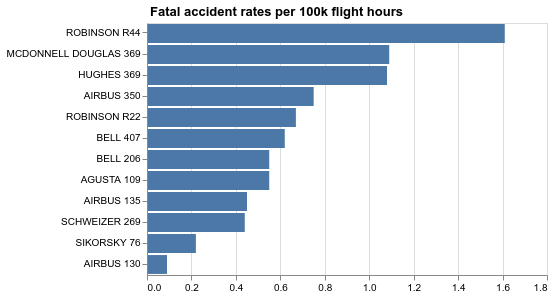

In [139]:
alt.Chart(model_totals, title="Fatal accident rates per 100k flight hours").mark_bar().encode(
    x=alt.X(
        "fatal_accidents_per_100k_hours:Q",
        axis=alt.Axis(title="")
    ),
    y=alt.Y(
        "latimes_make_and_model:N",
        axis=alt.Axis(title=""),
        sort=alt.EncodingSortField(
            field="fatal_accidents_per_100k_hours",
            op="sum",
            order="descending"
        )
    )
)


In [140]:
model_totals.sort_values("fatal_accidents_per_100k_hours", ascending=False)

,latimes_make_and_model,fatal_accidents,total_hours,fatal_accidents_per_100k_hours
9,ROBINSON R44,38,2359729,1.61
7,MCDONNELL DOUGLAS 369,6,550689,1.09
6,HUGHES 369,13,1201688,1.08
3,AIRBUS 350,29,3883490,0.75
8,ROBINSON R22,20,2970806,0.67
5,BELL 407,13,2113788,0.62
0,AGUSTA 109,2,362172,0.55
4,BELL 206,30,5501308,0.55
2,AIRBUS 135,4,884596,0.45
10,SCHWEIZER 269,5,1139326,0.44


What's the difference between Robinson R44 and the next highest rate?

In [141]:
f"{(1.61 - 1.09) / 1.09:.2f}%"

'0.48%'

Write out the data for use in a graphic.

In [142]:
model_totals.to_csv(
    os.path.join(output_dir, 'fatal-accident-rates.csv'),
    index=False,
    encoding="utf-8"
)

### Substituting Robinson's flight hours estimate

In an email to The Times, Robinson Helicopter Company President Kurt Robinson said he believed the FAA survey underestimates the R44's flight hours. He wrote:


> Please note, the fatal accident rate of 1.61per 100k flight hours used to compare the R44 with other model helicopters from 2006 to 2016 does not reflect the actual usage rate of the R44 helicopter. Your estimated flight hours are based on the FAA General Aviation Survey, which is a voluntary survey and more representative of larger commercial operators, not the U.S. helicopter industry as a whole. **Robinson’s own calculations, based on R44 production, overhaul records, and time-in-service reports, conservatively estimate total flight hours to be 3,260,787 hours**, 38% more than the FAA estimate.  

FAA official reject that claim and stand by their survey. But here is how the math comes up with Robinson's preferred flight hours total subsituted in.

In [143]:
adjusted_model_totals = model_totals.copy().set_index('latimes_make_and_model')

In [144]:
adjusted_model_totals.at['ROBINSON R44', 'total_hours'] = 3260787

In [145]:
adjusted_model_totals['fatal_accidents_per_100k_hours'] = adjusted_model_totals.apply(per_100k_hours, axis=1)

In [146]:
adjusted_model_totals.sort_values("fatal_accidents_per_100k_hours", ascending=False)

,fatal_accidents,total_hours,fatal_accidents_per_100k_hours
latimes_make_and_model,,,
ROBINSON R44,38,3260787,1.17
MCDONNELL DOUGLAS 369,6,550689,1.09
HUGHES 369,13,1201688,1.08
AIRBUS 350,29,3883490,0.75
ROBINSON R22,20,2970806,0.67
BELL 407,13,2113788,0.62
AGUSTA 109,2,362172,0.55
BELL 206,30,5501308,0.55
AIRBUS 135,4,884596,0.45


### What was the R44 fatal crash total in the period of our study including the year without FAA survey numbers?

In [147]:
annual_totals = us_helicopter_by_accident[
    us_helicopter_by_accident.latimes_make_and_model == 'ROBINSON R44'
].groupby("year").size().rename("total").reset_index()

In [148]:
annual_totals[(annual_totals.year >= 2006) & (annual_totals.year < 2017)]

,year,total
7,2006,7
8,2007,4
9,2008,5
10,2009,2
11,2010,4
12,2011,4
13,2012,4
14,2013,4
15,2014,5
16,2015,1


In [149]:
annual_totals[(annual_totals.year >= 2006) & (annual_totals.year < 2017)].total.sum()

42

### What is the total number of Robinson fatalities in the NTSB accident database?

In [150]:
maker_fatality_totals = helicopter_by_accident.groupby([
    "latimes_make", "in_usa"
]).agg(dict(total_fatalities="sum")).unstack(1)

In [151]:
maker_fatality_totals['grand_total'] = maker_fatality_totals.total_fatalities.sum(axis=1)

In [152]:
maker_fatality_totals.sort_values("grand_total", ascending=False).head()

total_fatalities        grand_total
in_usa                  False   True            
latimes_make                                    
BELL                    524.0  717.0      1241.0
ROBINSON                322.0  287.0       609.0
AIRBUS                  124.0  325.0       449.0
HUGHES                   44.0  151.0       195.0
SIKORSKY                 98.0   76.0       174.0

### In how many accidents have investigators noted signs of mast bumping?

The separate [search-narratives](src/search-narratives.ipynb) notebook searches through NTSB accident investigations for keywords related to mast-bumping.

In [153]:
%run ./src/search-narratives.ipynb

In [154]:
narratives = read_df("coded-narratives.csv")

The Times individually reviewed each hit in the search verified the fatal accident investigations that noted mast-bumping.

In [155]:
mast_bumping = narratives[narratives.verified == 'y']

Homemade helicopters will be excluded to prevent this small submarket from skewing the results.

In [156]:
mast_bumping = mast_bumping[mast_bumping.homemade == 'n']

Incidents after 1995 are notable because that was when the government issues new guidance on mast-bumping.

In [157]:
mast_bumping_since_1995 = mast_bumping[mast_bumping.year >= 1995]

In [158]:
len(mast_bumping_since_1995)

19

How many of these involved Robison helicopters?

In [159]:
mast_bumping_since_1995.groupby("latimes_make").size().rename("mast_bumping").reset_index()

,latimes_make,mast_bumping
0,BELL,5
1,FAIRCHILD/HILLER,3
2,GARLICK,1
3,ROBINSON,10


### How much experience do Robinson pilots in fatal accidents have?

Though the federal government does not track the flight hours of pilots across the board, it does log the experience level of those involved in accidents. Let's look into it.

Read in the pilot list

In [160]:
pilots = read_df("pilots.csv")

Filter down to accidents involving solo pilots. According to NTSB experts, this is the only way to ensure the analysis will focus on the pilot at the controls during the accident.

In [161]:
solo_pilot_accidents = us_helicopter_by_accident[
    (us_helicopter_by_accident.pilot_total == 1) &
    (us_helicopter_by_accident.year < 2018)
]

Merge pilot hours onto each accident.

In [162]:
solo_pilot_hours = solo_pilot_accidents.merge(
    pilots,
    on=["event_id", "aircraft_id"]
)

Toss out outliers with flight hour totals so large NTSB experts said they should be expected to be accurate.

In [163]:
solo_pilot_hours = solo_pilot_hours[solo_pilot_hours.flight_hours < 900000]

Groups the pilots by whether they were flying a Robinson helicopter or not.

In [164]:
solo_pilot_hours['maker_group'] = solo_pilot_hours.latimes_make.apply(
    lambda x: x if x == 'ROBINSON' else 'THE REST'
)

Chart the result

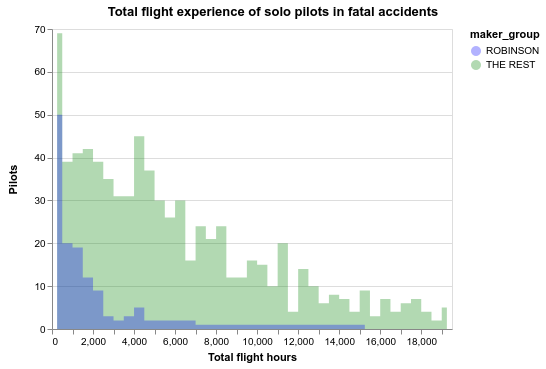

In [165]:
alt.Chart(
    solo_pilot_hours,
    title="Total flight experience of solo pilots in fatal accidents"
).mark_area(
    opacity=0.3,
    interpolate='step'
).encode(
    x=alt.X(
        'flight_hours:Q',
        bin=alt.Bin(maxbins=50),
        axis=alt.Axis(title="Total flight hours")
    ),
    y=alt.Y(
        'count(*):Q',
        stack=None,
        axis=alt.Axis(title="Pilots")
    ),
    color=alt.Color(
        'maker_group:N',
        scale=alt.Scale(range=['#0000ff', '#008000'])
    )
).transform_filter(alt.datum.flight_hours < 20000)

Look at the statistics

In [166]:
solo_pilot_hours[
    solo_pilot_hours.maker_group == 'ROBINSON'
].flight_hours.describe().reset_index()

,index,flight_hours
0,count,144.000000
1,mean,2508.299306
2,std,4665.660306
3,min,11.000000
4,25%,324.250000
5,50%,1017.500000
6,75%,2340.000000
7,max,31500.000000


In [167]:
solo_pilot_hours[
    solo_pilot_hours.maker_group == 'THE REST'
].flight_hours.describe().reset_index()

,index,flight_hours
0,count,798.000000
1,mean,6493.475815
2,std,5930.830156
3,min,6.000000
4,25%,2081.250000
5,50%,4730.500000
6,75%,9058.500000
7,max,37500.000000
